# Entrenamiento de YOLO

In [1]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd()+"/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = current_directory+"/masks"
data_directory = current_directory+"/data"

Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 train_models
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 image_analysis.ipynb
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb
	 cesga
	 segmentation_supervisada_pytorch copy 2.ipynb
	 segmentation_supervisada_pytorch copy 3.ipynb
	 data_files_1c_train_da.csv
	 yolov8n-seg.pt


Inspeccionamos el modelo from scratch para saber la entrada y la salida que espera

In [2]:
from ultralytics import YOLO
import torch

# Create a new YOLO model from scratch
model = YOLO("yolov8n-seg.pt", task='segment', verbose=True)

In [3]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_runnin

Modificamos el modelo para que en vez de recibir 3 capas de entrada reciba uno solo

In [4]:
model.model.model[0]

Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [5]:
old_conv_layer = model.model.model[0].conv
new_conv_layer = torch.nn.Conv2d(1, old_conv_layer.out_channels, kernel_size=old_conv_layer.kernel_size, stride=old_conv_layer.stride, padding=old_conv_layer.padding, bias=old_conv_layer.bias is not None)
model.model.model[0].conv = new_conv_layer
model.model.model[0].conv.weight.data = old_conv_layer.weight.sum(dim=1, keepdim=True)

In [6]:
# # Acceder a la capa de convolución inicial
# conv_layer = model.model.model[0].conv

# # Crear una nueva capa de convolución con 1 canal de entrada en lugar de 3
# new_conv_layer = torch.nn.Conv2d(1, conv_layer.out_channels, kernel_size=conv_layer.kernel_size, stride=conv_layer.stride, padding=conv_layer.padding, bias=conv_layer.bias is not None)

# # Reemplazar la capa de convolución en el modelo
# model.model.model[0].conv = new_conv_layer

# # Verificar la nueva configuración de la capa
# print(model.model.model[0])

# # Acceder a la capa de convolución inicial
# conv_layer = model.model.model[0].conv
# bn_layer = model.model.model[0].bn
# act_layer = model.model.model[0].act

# # Crear una nueva capa de convolución con 1 canal de entrada en lugar de 3
# new_conv_layer = torch.nn.Conv2d(1, 3, kernel_size=1, padding='same', bias=False)

# new_first_block = torch.nn.Sequential(new_conv_layer, conv_layer, bn_layer, act_layer)

# # Reemplazar la capa de convolución en el modelo
# model.model.model[0] = new_first_block

# # Verificar la nueva configuración de la capa
# print(model.model.model[0])

In [7]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2)
        )
        self.f = -1
        self.i = 0
    
    def forward(self, x):
        return self.model(x)
    
    def get_f(self):
        return self.f
    
    def set_f(self, f):
        self.f = f
        
model.model.model.append(MyModel())

Sequential(
  (0): Conv(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
        

Ahora que ya tenemos el modelo modificado, vamos a probar a cargarlo con nuestro Lightning Module personalizado para entrenarlo a nuestro manera

In [8]:
from pnebulae_torch.models import smpAdapter
import segmentation_models_pytorch as smp


model = model.model
conv_model = smpAdapter(model = model, learning_rate=0.0001, threshold=0.5, current_fold=0, loss_fn=smp.losses.DiceLoss, scheduler=None)

In [9]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.preprocess import CutValues
from pnebulae_torch.normalize import TypicalImageNorm
from torchvision import transforms


import pandas as pd

transform_x = transforms.Compose([
                    # MinMaxNorm,
                    CutValues(factor = 2),
                    TypicalImageNorm(factor = 1, substract=0),
                    # MinMaxImageNorm(min = -88.9933, max=125873.7500),
                    # ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 4096),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    # ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                    # transforms.ToTensor(),
                    # CustomPad(target_size = (1984, 1984), fill_min=True, tensor_type=torch.Tensor.float)
                    # ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = False, nbins = 256),
                    transforms.ToTensor(),
                    ])
type_fnc = torch.Tensor.int
transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: type_fnc(x.round())),
                    # CustomPad(target_size = (1984, 1984), fill = 0, tensor_type=torch.Tensor.int)
                    ])

df_train = pd.read_csv("data_files_1c_train.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

In [10]:
conv_model.train(True)

smpAdapter(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_

In [11]:
a = conv_model(dataset_train[156][0].unsqueeze(0))

In [12]:
a.shape

torch.Size([1, 1, 1024, 1024])

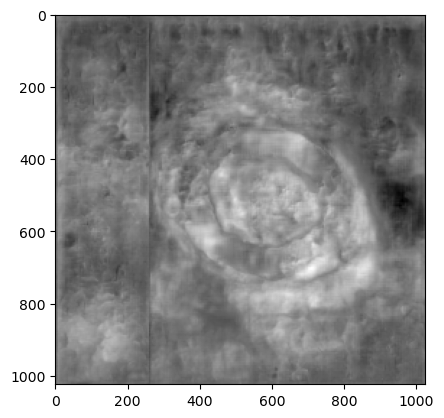

In [13]:
import matplotlib.pyplot as plt
plt.imshow(a[0][0].detach().numpy(), cmap='gray')

Vamos a intentar hacer un entrenamiento al igual que hacemos para el resto de modelos

In [14]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.preprocess import ApplyMorphology, ApplyIntensityTransformation, ApplyFilter, CustomPad, CutValues
from pnebulae_torch.normalize import TypicalImageNorm, MinMaxImageNorm
from pnebulae_torch.models.callbacks import PrintCallback
from pnebulae_torch.models import basicUNet, smpAdapter, ConvNet
from pnebulae_torch.utils import DivideWindowsSubset
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.model_selection import KFold
from torchvision import transforms
from skimage import morphology, exposure
from scipy import ndimage
from lightning.pytorch import seed_everything
from segmentation_models_pytorch.losses import DiceLoss
from lightning.pytorch.loggers import WandbLogger
import segmentation_models_pytorch as smp
import torch
import os
import pandas as pd
import lightning as L
import wandb
import inspect
import time
import gc

if __name__ == "__main__":
    ########## CONFIGURACIÓN SCRIPT ##########
    # Establecemos la clave de la API de W&B
    os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"
    ruta_logs_wandb = os.environ["STORE"] + "/TFG/logs_wandb/"
    
    torch.set_float32_matmul_precision('high')
    
    ####### CONFIGURACIÓN ENTRENAMIENTO #######
    model_name = "YOLO_test"
    
    BATCH_SIZE = 124
    num_epochs = 2000
    lr = 1e-2
    window_shape = 640
    
    k = 5
    
    loss_fn = DiceLoss
    activation_layer=torch.nn.ReLU
    
    if "mode" in inspect.signature(loss_fn).parameters:
        type_fnc = torch.Tensor.int
    else:
        type_fnc = torch.Tensor.float
        
    ############# CARGA DATASET #############
    transform_x = transforms.Compose([
                        # MinMaxNorm,
                        CutValues(factor = 2),
                        TypicalImageNorm(factor = 1, substract=0),
                        # MinMaxImageNorm(min = -88.9933, max=125873.7500),
                        # ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                        # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                        # ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 4096),
                        # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                        # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                        # ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                        # transforms.ToTensor(),
                        # CustomPad(target_size = (1984, 1984), fill_min=True, tensor_type=torch.Tensor.float)
                        # ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = False, nbins = 256),
                        transforms.ToTensor(),
                        ])

    transform_y = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: type_fnc(x.round())),
                        # CustomPad(target_size = (1984, 1984), fill = 0, tensor_type=torch.Tensor.int)
                        ])

    df_train = pd.read_csv("data_files_1c_train.csv")
    dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))
    
    df_test = pd.read_csv("data_files_1c_test.csv")
    dataset_test = NebulaeDataset(data_directory, masks_directory, df_test, transform = (transform_x, transform_y))

    seed_everything(42, workers = True)
    
    ########## ENTRENAMIENTO MODELO ##########
    # Definimos el K-fold Cross Validator
    kfold = KFold(n_splits=k, shuffle=True, random_state = 42)
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_train)):
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath=os.environ["STORE"] + f"/TFG/model_checkpoints/{model_name}",
            filename='best_model-{epoch:02d}-'+str(fold),
            save_top_k=1,
            mode='min',
        )
        
        checkpoint_callback_last = ModelCheckpoint(
            monitor=None,
            dirpath=os.environ["STORE"] + f"/TFG/model_checkpoints/{model_name}",
            filename='last_model_fold'+str(fold),
        )
        
        callbacks = [PrintCallback(), LearningRateMonitor(logging_interval='epoch'), checkpoint_callback, checkpoint_callback_last]
        
        # Acceder a la capa de convolución inicial
        model = YOLO("yolov8n-seg.yaml", task='segment')
        
        old_conv_layer = model.model.model[0].conv
        new_conv_layer = torch.nn.Conv2d(1, old_conv_layer.out_channels, kernel_size=old_conv_layer.kernel_size, stride=old_conv_layer.stride, padding=old_conv_layer.padding, bias=old_conv_layer.bias is not None)
        model.model.model[0].conv = new_conv_layer
        model.model.model[0].conv.weight.data = old_conv_layer.weight.sum(dim=1, keepdim=True)

        class MyModel(nn.Module):
            def __init__(self):
                super(MyModel, self).__init__()
                self.model = torch.nn.Sequential(
                    torch.nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
                    torch.nn.Upsample(scale_factor=2),
                    torch.nn.Upsample(scale_factor=2)
                )
                self.f = -1
                self.i = 0
            
            def forward(self, x):
                return self.model(x)
            
            def get_f(self):
                return self.f
            
            def set_f(self, f):
                self.f = f
                
        model.model.model.append(MyModel())
        # # Acceder a la capa de convolución inicial
        # conv_layer = model.model.model[0].conv
        # bn_layer = model.model.model[0].bn
        # act_layer = model.model.model[0].act

        # # Crear una nueva capa de convolución con 1 canal de entrada en lugar de 3
        # new_conv_layer = torch.nn.Conv2d(1, 3, kernel_size=1, padding='same', bias=False)

        # new_first_block = torch.nn.Sequential(new_conv_layer, conv_layer, bn_layer, act_layer)

        # # Reemplazar la capa de convolución en el modelo
        # model.model.model[0] = new_first_block
        
        model = model.model
        # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
        # model = smpAdapter(model = model, learning_rate=lr, threshold=0.5, current_fold=fold, loss_fn=loss_fn, scheduler=None)
        # model = smpAdapter(model = model, learning_rate=lr, threshold=0.5, current_fold=fold, loss_fn=loss_fn, scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau, mode='min', factor=0.1, patience=500, cooldown=150, verbose=False)
        # model = smpAdapter(model = model, learning_rate=lr, threshold=0.5, current_fold=fold, loss_fn=loss_fn, scheduler=torch.optim.lr_scheduler.StepLR, step_size = 2000, gamma = 0.1, verbose=False)
        model = smpAdapter(model = model, learning_rate=lr, threshold=0.5, current_fold=fold, loss_fn=loss_fn, scheduler=torch.optim.lr_scheduler.MultiStepLR, milestones = [250, 750, 1500], gamma = 0.1, verbose=False)
        
        ruta_logs_wandb = os.environ["STORE"] + "/TFG/logs_wandb/"
        logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name=model_name, save_dir=ruta_logs_wandb)
        logger_wandb.experiment.config.update({"model_name": model_name})

        # log gradients, parameter histogram and model topology
        logger_wandb.watch(model, log="all")

        trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=2, logger= logger_wandb, callbacks=callbacks)

        # Imprimimos el fold del que van a mostrarse los resultados
        print('--------------------------------')
        print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

        # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
        train_subset = torch.utils.data.Subset(dataset_train, train_ids)
        val_subset = torch.utils.data.Subset(dataset_train, val_ids)
        
        if window_shape is not None:
            train_subset = DivideWindowsSubset(train_subset, window_shape = window_shape, fill_min = True)
            val_subset = DivideWindowsSubset(val_subset, window_shape = window_shape, fill_min = True)
        
        # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
        trainloader = torch.utils.data.DataLoader(
                                train_subset,
                                batch_size=BATCH_SIZE, num_workers=6, shuffle=True, persistent_workers=False)

        valloader = torch.utils.data.DataLoader(
                                val_subset,
                                batch_size=BATCH_SIZE, num_workers=6, shuffle=False, persistent_workers=False)
        
        # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
        trainer.fit(model, trainloader, valloader) 

        logger_wandb.experiment.unwatch(model)

        # testloader = torch.utils.data.DataLoader(
        #                         dataset_test,
        #                         batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)
        
        # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
        # trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb, callbacks=callbacks)
        # trainer_test.test(model, testloader)

        logger_wandb.finalize("success")
        wandb.finish()
        
        del model
        del trainer
        
        torch.cuda.empty_cache()
        time.sleep(30)

[rank: 0] Seed set to 42


wandb: Currently logged in as: edluksss (edluksss_org). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


--------------------------------
Model info:
	- Batch Size: 124
	- GPUs on use: 1


/mnt/netapp2/Store_uni/home/ulc/co/ela/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/netapp2/Store_uni/home/ulc/co/ela/TFG/model_checkpoints/YOLO_test exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | SegmentationModel | 3.3 M 
1 | loss_fn | DiceLoss          | 0     
----------------------------------------------
3.3 M     Trainable params
16        Non-trainable params
3.3 M     Total params
13.054    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training is started!


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import torch
from ultralytics import YOLO
import ultralytics

# Definir una función para imprimir la forma de los tensores
def print_tensor_shape(tensor, name):
    print(f"{name} shape: {tensor.shape}")

# Cargar el modelo YOLOv8 preentrenado
model = YOLO('yolov8n-seg.yaml')

# Acceder a la capa de convolución inicial
conv_layer = model.model.model[0].conv
bn_layer = model.model.model[0].bn
act_layer = model.model.model[0].act

# Crear una nueva capa de convolución con 1 canal de entrada en lugar de 3
new_conv_layer = torch.nn.Conv2d(1, 3, kernel_size=1, padding='same', bias=False)

# Crear un nuevo bloque inicial
new_first_block = torch.nn.Sequential(new_conv_layer, conv_layer, bn_layer, act_layer)

# Reemplazar el bloque inicial en el modelo
model.model.model[0] = new_first_block

# Modificar la función forward para imprimir la forma de los tensores
class CustomModel(torch.nn.Module):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model

    def forward(self, x):
        print_tensor_shape(x, "Input")
        for i, layer in enumerate(self.model):
            if isinstance(layer, torch.nn.modules.container.Sequential):
                for j, sublayer in enumerate(layer):
                    x = sublayer(x)
                    print_tensor_shape(x, f"Layer {i}-{j}")
            elif isinstance(layer, torch.nn.modules.container.ModuleList):
                outputs = []
                for j, sublayer in enumerate(layer):
                    output = sublayer(x)
                    outputs.append(output)
                    print_tensor_shape(output, f"Layer {i}-{j}")
                x = outputs
            # Verificar si la capa es Concat y si x es una lista o tupla
            elif isinstance(layer, ultralytics.nn.modules.conv.Concat):
                print(f"Layer {i} Concat")
                x = list(x)
            else:
                x = layer(x)
                print_tensor_shape(x, f"Layer {i}")
        return x

# Crear una instancia del modelo personalizado
custom_model = CustomModel(model.model.model)

# Verificar la nueva configuración de la capa
print(custom_model)

# Continuar con el resto del código
model = smpAdapter(model=custom_model, learning_rate=lr, threshold=0.5, current_fold=fold, loss_fn=loss_fn, scheduler=None)

# Configuración del logger
ruta_logs_wandb = os.environ["STORE"] + "/TFG/logs_wandb/"
logger_wandb = WandbLogger(project="segmentation_TFG", log_model=False, name=model_name, save_dir=ruta_logs_wandb)
logger_wandb.experiment.config.update({"model_name": model_name})

# Registrar el modelo en WandbLogger
logger_wandb.watch(model, log="all")

# Configuración del entrenador
trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=2, logger=logger_wandb, callbacks=callbacks)

# Imprimir información del modelo
print('--------------------------------')
print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

# Crear subsets de PyTorch
train_subset = torch.utils.data.Subset(dataset_train, train_ids)
val_subset = torch.utils.data.Subset(dataset_train, val_ids)

if window_shape is not None:
    train_subset = DivideWindowsSubset(train_subset, window_shape=window_shape, fill_min=True)
    val_subset = DivideWindowsSubset(val_subset, window_shape=window_shape, fill_min=True)

# Definir data loaders
trainloader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=BATCH_SIZE, num_workers=6, shuffle=True, persistent_workers=False
)

valloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=BATCH_SIZE, num_workers=6, shuffle=False, persistent_workers=False
)

# Entrenar el modelo
trainer.fit(model, trainloader, valloader)




In [ ]:
import torch

# Crear los tensores de ejemplo
tensor1 = torch.randn(1, 128, 8, 8)
tensor2 = torch.randn(1, 128, 8, 8)
tensor3 = torch.randn(1, 128, 8, 8)
tensor4 = torch.randn(1, 128, 8, 8)

# Crear una lista con los tensores
tensor_list = [tensor1, tensor2, tensor3, tensor4]

# Concatenar los tensores en la dimensión 1
result = torch.cat(tensor_list, dim=1)

print(result.shape)


In [ ]:
x = list(torch.randn(2, 3, 640, 640))
a = torch.cat(x, 0)

In [ ]:
a.shape

In [ ]:
import ultralytics
ultralytics.nn.modules.conv.Concat()

In [ ]:
model.model.model[12]